# Hospital Readmission Prediction - Feature Engineering

This notebook focuses on feature engineering for the hospital readmission prediction model. We'll transform raw features into more informative ones and prepare the data for modeling.

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
import warnings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

## 1. Load the Data

In [73]:
data = pd.read_csv('diabetic_data.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


## 2. Basic Preprocessing

In [74]:
print(f"Dataset shape: {data.shape}")

Dataset shape: (101766, 50)


Droped column which has more than 40% missing value

In [75]:
import numpy as np
import pandas as pd
data = data.replace('?', np.nan)
missing_threshold = 0.4
high_missing = data.columns[data.isnull().mean() > missing_threshold]
print("Columns with more than 40% missing values:")
print(high_missing.tolist())
data.drop(columns=high_missing, inplace=True)

Columns with more than 40% missing values:
['weight', 'medical_specialty', 'max_glu_serum', 'A1Cresult']


In [76]:
print(f"Dataset shape: {data.shape}")

Dataset shape: (101766, 46)


In [77]:
missing_count = data.isna().sum()
missing_percent = (data.isna().mean() * 100).round(2)
missing_info = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing %': missing_percent
})
missing_info = missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)
print(missing_info)

            Missing Count  Missing %
payer_code          40256      39.56
race                 2273       2.23
diag_3               1423       1.40
diag_2                358       0.35
diag_1                 21       0.02


missing vlaue in payer_code and race column have imputed by mode

In [78]:
for col in ['payer_code', 'race']:
    mode_val = data[col].mode()[0]
    data[col] = data[col].fillna(mode_val)

In [79]:
cols = ['diag_1', 'diag_2', 'diag_3']
total_nans = data[cols].isna().sum().sum()
print("Total NaN values in diag_1, diag_2, and diag_3:", total_nans)

Total NaN values in diag_1, diag_2, and diag_3: 1802


missing value in 3 diagonsis column imputed by 00

In [80]:
cols = ['diag_1', 'diag_2', 'diag_3']
data[cols] = data[cols].fillna('00')

In [81]:
cols = ['diag_1', 'diag_2', 'diag_3']
total_nans = data[cols].isna().sum().sum()
print("Total NaN values in diag_1, diag_2, and diag_3:", total_nans)

Total NaN values in diag_1, diag_2, and diag_3: 0


Groupby in admission_type_id column

In [82]:
#Map IDs to Meaningful Labels
admission_type_map = {
    1: 'Emergency',
    2: 'Urgent',
    3: 'Elective',
    4: 'Newborn',
    5: 'Not Available',
    6: 'NULL',
    7: 'Trauma Center',
    8: 'Not Mapped'
}
data['admission_type'] = data['admission_type_id'].map(admission_type_map)
data['admission_type'] = data['admission_type'].replace(
    ['Not Available', 'NULL', 'Not Mapped'], 'Unknown'
)
data.drop(columns=['admission_type_id'], inplace=True)

In [83]:
print(data['admission_type'].value_counts())
print("\nNumber of unique admission types:", data['admission_type'].nunique())

admission_type
Emergency        53990
Elective         18869
Urgent           18480
Unknown          10396
Trauma Center       21
Newborn             10
Name: count, dtype: int64

Number of unique admission types: 6


Groupby in discharge_disposition_id column

In [84]:
def map_discharge(value):
    if value in [1, 6, 8]:
        return 'home'
    elif value in [2,3,4,5,7,9,10,12,15,16,17,22,23,24,27,28,29,30]:
        return 'transferred'
    elif value in [11,13,14,19,20,21]:
        return 'expired/hospice'
    else:
        return 'other'
data['discharge_group'] = data['discharge_disposition_id'].apply(map_discharge)
data['discharge_group'].value_counts()
data.drop(['discharge_disposition_id'], axis=1, inplace=True)

In [85]:

# 1. Map age intervals to three broader age groups
age_group_map = {
    '[0-10)': 'young',
    '[10-20)': 'young',
    '[20-30)': 'young',
    '[30-40)': 'middle-aged',
    '[40-50)': 'middle-aged',
    '[50-60)': 'middle-aged',
    '[60-70)': 'older',
    '[70-80)': 'older',
    '[80-90)': 'older',
    '[90-100)': 'older'
}

data['age_group_3cat'] = data['age'].map(age_group_map)
data.drop(['age'], axis=1, inplace=True)

In [86]:
data['age_group_3cat'].value_counts()

,count
age_group_3cat,
older,68541
middle-aged,30716
young,2509


Groupby in admission_source_id column

In [87]:
# Mapping dictionary
admission_source_map = {
    1: 'Referral',
    2: 'Referral',
    3: 'Referral',
    4: 'Transfer from Facility',
    5: 'Transfer from Facility',
    6: 'Transfer from Facility',
    7: 'Emergency',
    8: 'Legal/Court',
    9: 'Other/Unknown',
    10: 'Transfer from Facility',
    11: 'Birth-Related',
    12: 'Birth-Related',
    13: 'Birth-Related',
    14: 'Birth-Related',
    15: 'Other/Unknown',
    17: 'Other/Unknown',
    18: 'Transfer from Facility',
    19: 'Transfer from Facility',
    20: 'Other/Unknown',
    21: 'Other/Unknown',
    22: 'Transfer from Facility',
    23: 'Birth-Related',
    24: 'Birth-Related',
    25: 'Transfer from Facility',
    26: 'Transfer from Facility'
}

# Apply mapping
data['admission_source_grouped'] = data['admission_source_id'].map(admission_source_map)
data.drop(['admission_source_id'], axis=1, inplace=True)

In [88]:
data['admission_source_grouped'].value_counts()

,count
admission_source_grouped,
Emergency,57494
Referral,30856
Other/Unknown,7067
Transfer from Facility,6328
Legal/Court,16
Birth-Related,5


Groupby in diag column and other diagonsis column

In [89]:
# First, convert diagnosis column to numeric safely (some values may be strings like 'V45')
def safe_float(x):
    try:
        return float(x)
    except:
        return np.nan

data['diag_1_code'] = data['diag_1'].apply(safe_float)

# Define a function to group ICD-9 codes
def group_diagnosis(code):
    if pd.isna(code):
        return 'Unknown'
    if (390 <= code <= 459) or (code == 785):
        return 'Circulatory'
    elif (460 <= code <= 519) or (code == 786):
        return 'Respiratory'
    elif (520 <= code <= 579) or (code == 787):
        return 'Digestive'
    elif 250 <= code < 251:
        return 'Diabetes'
    elif 800 <= code <= 999:
        return 'Injury'
    elif 710 <= code <= 739:
        return 'Musculoskeletal'
    elif (580 <= code <= 629) or (code == 788):
        return 'Genitourinary'
    elif 140 <= code <= 239:
        return 'Neoplasms'
    elif code in [780, 781, 784] or (790 <= code <= 799):
        return 'Symptoms'
    elif (240 <= code <= 279) and not (250 <= code < 251):
        return 'Endocrine (non-diabetes)'
    elif (680 <= code <= 709) or (code == 782):
        return 'Skin'
    elif 1 <= code <= 139:
        return 'Infectious'
    elif 290 <= code <= 319:
        return 'Mental'
    elif str(code).startswith('E') or str(code).startswith('V'):
        return 'External Causes'
    elif 280 <= code <= 289:
        return 'Blood'
    elif 320 <= code <= 359:
        return 'Nervous'
    elif 630 <= code <= 679:
        return 'Pregnancy'
    elif 360 <= code <= 389:
        return 'Sense Organs'
    elif 740 <= code <= 759:
        return 'Congenital'
    else:
        return 'Other'
data['diagnosis_grouped'] = data['diag_1_code'].apply(group_diagnosis)
data.drop(['diag_1','diag_2','diag_3','diag_1_code'], axis=1, inplace=True)

In [90]:
data['diagnosis_grouped'].value_counts()

,count
diagnosis_grouped,
Circulatory,30437
Respiratory,14423
Digestive,9475
Diabetes,8757
Injury,6974
Genitourinary,5117
Musculoskeletal,4957
Neoplasms,3433
Infectious,2768


In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 44 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   time_in_hospital          101766 non-null  int64 
 5   payer_code                101766 non-null  object
 6   num_lab_procedures        101766 non-null  int64 
 7   num_procedures            101766 non-null  int64 
 8   num_medications           101766 non-null  int64 
 9   number_outpatient         101766 non-null  int64 
 10  number_emergency          101766 non-null  int64 
 11  number_inpatient          101766 non-null  int64 
 12  number_diagnoses          101766 non-null  int64 
 13  metformin                 101766 non-null  object
 14  repa

## 3. Feature Engineering

Merge inpatient, outpatient, and emergency column in a one column

In [92]:
import pandas as pd
def classify_visit(row):
    inpatient = row['number_inpatient']
    outpatient = row['number_outpatient']
    emergency = row['number_emergency']

    if emergency > 0:
        return 'emergency'
    elif inpatient > 10:
        return 'high_inpatient'
    elif inpatient > 0:
        return 'low_inpatient'
    elif outpatient >= 19:
        return 'high_outpatient_rate'
    elif outpatient > 0:
        return 'low_outpatient_rate'
    else:
        return 'novisit'
data['VisitType'] = data.apply(classify_visit, axis=1)
data.drop(['number_inpatient', 'number_outpatient', 'number_emergency'], axis=1, inplace=True)

In [93]:
print(f"Dataset shape: {data.shape}")

Dataset shape: (101766, 42)


In [ ]:
# # 3.2 Create age groups
# bins = [0, 40, 65, 75, 100]
# labels = ['<40', '40-65', '65-75', '>75']
# data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels)

# # Visualize readmission rate by age group
# age_group_readmission = data.groupby('age_group')['readmission_30d'].mean() * 100

# plt.figure(figsize=(10, 6))
# age_group_readmission.plot(kind='bar')
# plt.title('Readmission Rate by Age Group')
# plt.xlabel('Age Group')
# plt.ylabel('Readmission Rate (%)')
# plt.show()

In [ ]:
# # 3.3 Create interaction features
# data['age_heart_failure'] = data['age'] * data['heart_failure']
# data['age_diabetes'] = data['age'] * data['diabetes']
# data['previous_emergency'] = data['previous_admissions'] * data['emergency_admission']
# data['medication_count_adherence'] = data['medication_count'] * data['medication_adherence']
# data['comorbidity_count'] = data[['diabetes', 'heart_failure', 'copd', 'hypertension', 'renal_disease']].sum(axis=1)

# # Visualize readmission rate by comorbidity count
# comorbidity_readmission = data.groupby('comorbidity_count')['readmission_30d'].mean() * 100

# plt.figure(figsize=(10, 6))
# comorbidity_readmission.plot(kind='bar')
# plt.title('Readmission Rate by Number of Comorbidities')
# plt.xlabel('Number of Comorbidities')
# plt.ylabel('Readmission Rate (%)')
# plt.show()

In [ ]:
# 3.4 Create risk score based on domain knowledge
# data['risk_score'] = (
#     0.2 * (data['age'] > 75).astype(int) +
#     0.15 * data['diabetes'] +
#     0.25 * data['heart_failure'] +
#     0.2 * data['copd'] +
#     0.1 * data['renal_disease'] +
#     0.05 * (data['previous_admissions'] > 2).astype(int) +
#     0.15 * (data['medication_count'] > 8).astype(int) -
#     0.3 * data['medication_adherence'] +
#     0.1 * data['emergency_admission'] +
#     0.1 * (data['discharge_disposition'] == 2).astype(int)
# )

# # Visualize risk score distribution by readmission status
# plt.figure(figsize=(10, 6))
# sns.histplot(data=data, x='risk_score', hue='readmission_30d', bins=30, multiple='dodge')
# plt.title('Risk Score Distribution by Readmission Status')
# plt.xlabel('Risk Score')
# plt.ylabel('Count')
# plt.legend(['Not Readmitted', 'Readmitted'])
# plt.show()

In [94]:
# Step 1: Identify object columns, excluding 'readmitted'
categorical_cols = data.select_dtypes(include='object').columns
categorical_cols = categorical_cols.drop('readmitted')  # Exclude target

# Step 2: Apply One-Hot Encoding
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=False)

# Step 3: Your target column 'readmitted' stays untouched
print(data_encoded.shape)
print(data_encoded.columns)

(101766, 153)
Index(['encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses', 'readmitted', 'race_AfricanAmerican', 'race_Asian',
       ...
       'diagnosis_grouped_Sense Organs', 'diagnosis_grouped_Skin', 'diagnosis_grouped_Symptoms', 'diagnosis_grouped_Unknown', 'VisitType_emergency', 'VisitType_high_inpatient', 'VisitType_high_outpatient_rate', 'VisitType_low_inpatient', 'VisitType_low_outpatient_rate', 'VisitType_novisit'], dtype='object', length=153)


## 4. Feature Selection

In [96]:
# Prepare data for feature selection
# Drop non-feature columns
X = data_encoded.drop(columns=['readmitted'])
y = data_encoded['readmitted']

print(f"Features shape: {X.shape}")

Features shape: (101766, 152)


In [100]:
# Train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Create a DataFrame for feature importances
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Format to 4 decimal places
feature_importance_df['Importance'] = feature_importance_df['Importance'].round(4)

# Sort in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print all
print("All feature importances (sorted to 4 decimal places):")
print(feature_importance_df.to_string(index=False))

All feature importances (sorted to 4 decimal places):
                                        Feature  Importance
                                   encounter_id      0.1022
                                    patient_nbr      0.1008
                             num_lab_procedures      0.0836
                                num_medications      0.0761
                               time_in_hospital      0.0580
                               number_diagnoses      0.0406
                                 num_procedures      0.0393
                              VisitType_novisit      0.0189
                  diagnosis_grouped_Circulatory      0.0154
                                    gender_Male      0.0147
                                  gender_Female      0.0146
                        VisitType_low_inpatient      0.0122
                                 race_Caucasian      0.0114
                                  payer_code_MC      0.0111
                  diagnosis_grouped_Respirator

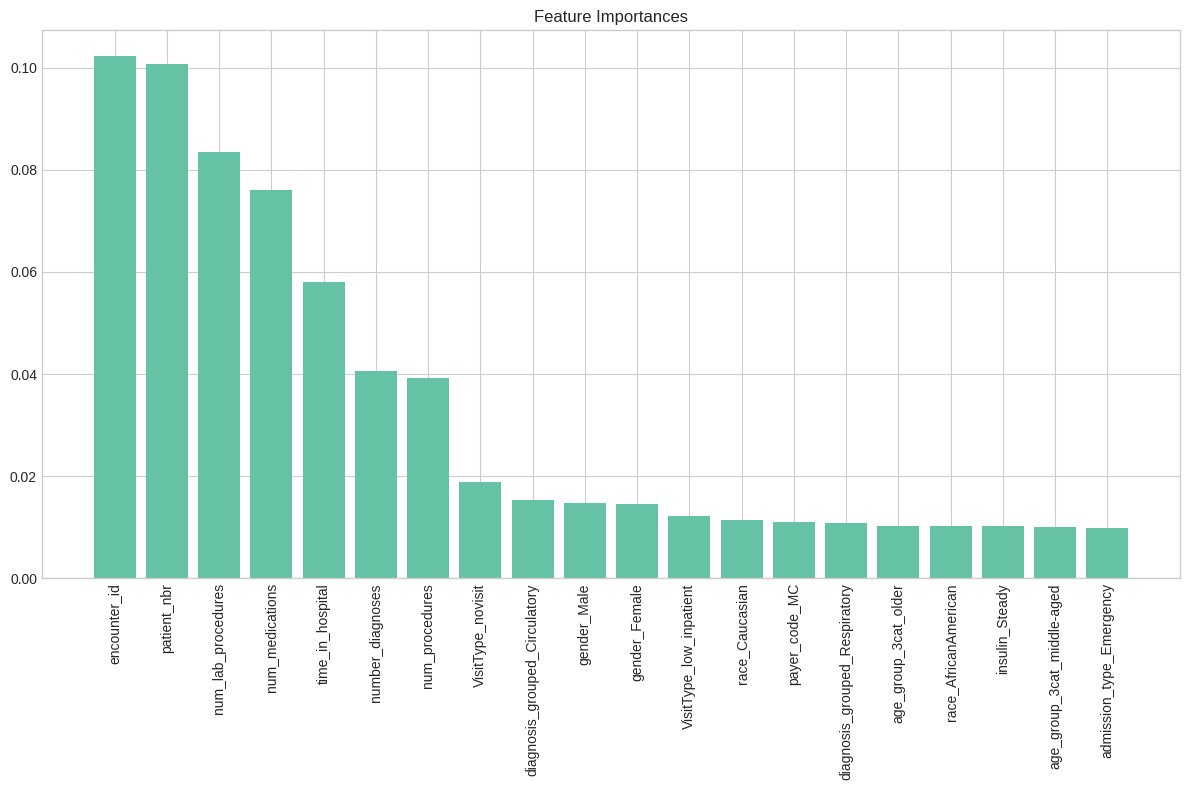

Top 20 features by importance:
1. encounter_id: 0.1022
2. patient_nbr: 0.1008
3. num_lab_procedures: 0.0836
4. num_medications: 0.0761
5. time_in_hospital: 0.0580
6. number_diagnoses: 0.0406
7. num_procedures: 0.0393
8. VisitType_novisit: 0.0189
9. diagnosis_grouped_Circulatory: 0.0154
10. gender_Male: 0.0147
11. gender_Female: 0.0146
12. VisitType_low_inpatient: 0.0122
13. race_Caucasian: 0.0114
14. payer_code_MC: 0.0111
15. diagnosis_grouped_Respiratory: 0.0108
16. age_group_3cat_older: 0.0103
17. race_AfricanAmerican: 0.0103
18. insulin_Steady: 0.0103
19. age_group_3cat_middle-aged: 0.0101
20. admission_type_Emergency: 0.0098


In [101]:
# 4.1 Feature importance using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the top 20 features
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), X.columns[indices][:20], rotation=90)
plt.tight_layout()
plt.show()
print("Top 20 features by importance:")
for i in range(20):
    print(f"{i+1}. {X.columns[indices][i]}: {importances[indices][i]:.4f}")

In [ ]:
# 4.2 Statistical feature selection using ANOVA F-value
selector = SelectKBest(f_classif, k=20)
X_new = selector.fit_transform(X, y)

# Get selected feature names
mask = selector.get_support()
selected_features = X.columns[mask]

# Get scores
scores = selector.scores_
selected_scores = scores[mask]

# Sort by score
sorted_indices = np.argsort(selected_scores)[::-1]
sorted_features = selected_features[sorted_indices]
sorted_scores = selected_scores[sorted_indices]

# Plot
plt.figure(figsize=(12, 8))
plt.title('Feature Selection using ANOVA F-value')
plt.bar(range(len(sorted_features)), sorted_scores, align='center')
plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
plt.tight_layout()
plt.show()

print("Top 20 features by ANOVA F-value:")
for i, (feature, score) in enumerate(zip(sorted_features, sorted_scores)):
    print(f"{i+1}. {feature}: {score:.4f}")

In [ ]:
# 4.3 Recursive Feature Elimination (RFE)
rfe = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=20)
rfe.fit(X, y)

# Get selected feature names
rfe_mask = rfe.get_support()
rfe_features = X.columns[rfe_mask]

print("Top 20 features selected by RFE:")
for i, feature in enumerate(rfe_features):
    print(f"{i+1}. {feature}")

## 5. Compare Feature Selection Methods

In [ ]:
# Compare the features selected by different methods
rf_features = X.columns[indices][:20]
anova_features = sorted_features

# Find common features
common_all = set(rf_features) & set(anova_features) & set(rfe_features)
common_rf_anova = set(rf_features) & set(anova_features)
common_rf_rfe = set(rf_features) & set(rfe_features)
common_anova_rfe = set(anova_features) & set(rfe_features)

print(f"Features common to all methods: {len(common_all)}")
print(f"Features common to RF and ANOVA: {len(common_rf_anova)}")
print(f"Features common to RF and RFE: {len(common_rf_rfe)}")
print(f"Features common to ANOVA and RFE: {len(common_anova_rfe)}")

print("\nFeatures common to all methods:")
for feature in common_all:
    print(f"- {feature}")

## 6. Final Feature Set

In [ ]:
# Create a final feature set based on the analysis
# We'll use features that appear in at least 2 of the 3 methods
all_selected_features = list(rf_features) + list(anova_features) + list(rfe_features)
feature_counts = pd.Series(all_selected_features).value_counts()
final_features = feature_counts[feature_counts >= 2].index.tolist()

print(f"Final feature set size: {len(final_features)}")
print("\nFinal features:")
for feature in final_features:
    print(f"- {feature}")

In [ ]:
# Create the final feature matrix
X_final = X[final_features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

# Convert back to DataFrame for better visualization
X_scaled_data = pd.DataFrame(X_scaled, columns=X_final.columns)

print(f"Final scaled feature matrix shape: {X_scaled_data.shape}")
X_scaled_data.head()

## 7. Save Processed Data

In [ ]:
# Save the final feature set for reference
import os
os.makedirs('../data/features', exist_ok=True)

# Save the list of final features
with open('../data/features/final_features.txt', 'w') as f:
    for feature in final_features:
        f.write(f"{feature}\n")

print(f"Final feature list saved to ../data/features/final_features.txt")

In [ ]:
# Save the full processed dataset
# Add the target variable back
X_scaled_data['readmission_30d'] = y.values

# Save to CSV
X_scaled_data.to_csv('../data/features/processed_features.csv', index=False)
print(f"Processed features saved to ../data/features/processed_features.csv")

## 8. Summary of Feature Engineering

In this notebook, we performed several feature engineering steps:

1. **Temporal Features**:
   - Extracted month, day of week, and quarter from admission date
   - Created a weekend admission indicator

2. **Categorical Transformations**:
   - Created age groups
   - One-hot encoded categorical variables

3. **Interaction Features**:
   - Combined age with medical conditions
   - Created previous emergency admissions
   - Combined medication count and adherence
   - Created comorbidity count

4. **Domain Knowledge Features**:
   - Created a risk score based on clinical factors

5. **Feature Selection**:
   - Used Random Forest importance
   - Applied ANOVA F-value selection
   - Performed Recursive Feature Elimination
   - Selected features that appeared in at least 2 methods

6. **Feature Scaling**:
   - Standardized the final feature set

The final feature set includes a mix of demographic, medical, temporal, and interaction features that show strong predictive power for hospital readmissions.